In [1]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


In [3]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

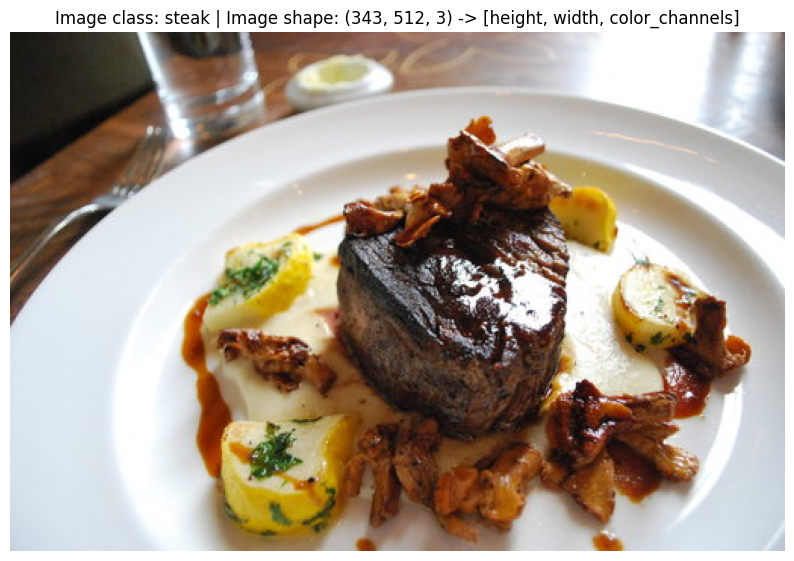

In [4]:
import random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Set seed
random.seed(41) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Turn the image into an array
img_as_array = np.asarray(img)

# 6. Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

In [5]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

train_image_path = list(train_dir.glob("*/*.jpg"))
test_image_path = list(test_dir.glob("*/*.jpg"))

In [23]:
# transform image to tensor
# with augmentation
train_data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
# without augmentation
test_data_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

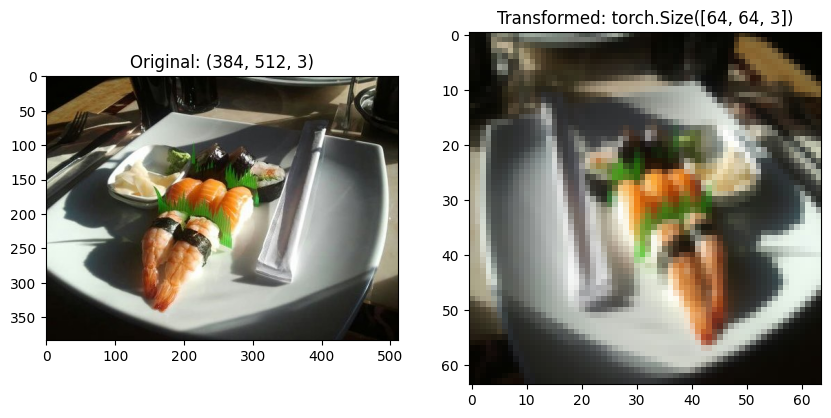

In [7]:
# see a sample
sample_data = random.sample(train_image_path, k=1)
img = Image.open(sample_data[0])

fig, axs = plt.subplots(1,2, figsize=(10,10))
# original
img_as_array = np.asarray(img)
axs[0].imshow(img_as_array)
axs[0].set_title(f'Original: {img_as_array.shape}')
# transformed
img_tensor = train_data_transform(img).permute(1, 2, 0)
axs[1].imshow(img_tensor)
axs[1].set_title(f'Transformed: {img_tensor.shape}')

plt.show()

### in-built ImageFolder

In [27]:
train_data = datasets.ImageFolder(root=train_dir, transform=train_data_transform)
test_data = datasets.ImageFolder(root=test_dir, transform=test_data_transform)

# some info
print(train_data.classes)
print(train_data[0][0].shape)
print(len(train_data), len(test_data))
print(train_data.class_to_idx)

['pizza', 'steak', 'sushi']
torch.Size([3, 64, 64])
225 75
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [34]:
import os

train_data_loader = DataLoader(dataset=train_data, batch_size=16, num_workers=os.cpu_count())
test_data_loader = DataLoader(dataset=test_data, batch_size=16, num_workers=os.cpu_count())

---------------------

### Custom ImageFolder

In [19]:
import os
import pathlib
import torch
from torch.utils.data import Dataset

# function to find classes
def find_classes(dir_path):
  classes = sorted([entry.name for entry in list(os.scandir(dir_path))])
  class_to_idx = {class_ : idx for idx, class_ in enumerate(classes)}
  return classes, class_to_idx

# custom image reader
class ImageFolderCustom(Dataset):
  def __init__(self, root, transform=None):
    self.path = list(pathlib.Path(root).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(root)

  def __len__(self):
    return len(self.path)

  def __getitem__(self, index):
    img = Image.open(self.path[index])
    class_name = self.path[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform is not None:
      img = self.transform(img)

    return img, class_idx

In [26]:
train_data_custom = ImageFolderCustom(root=train_dir, transform=train_data_transform)
test_data_custom = ImageFolderCustom(root=test_dir, transform=test_data_transform)

# some info
print(train_data_custom.classes)
print(train_data_custom[0][0].shape)
print(len(train_data_custom), len(test_data_custom))
print(train_data_custom.class_to_idx)

['pizza', 'steak', 'sushi']
torch.Size([3, 64, 64])
225 75
{'pizza': 0, 'steak': 1, 'sushi': 2}


In [35]:
import os

train_data_loader_custom = DataLoader(dataset=train_data_custom, batch_size=16, num_workers=os.cpu_count())
test_data_loader_custom = DataLoader(dataset=test_data_custom, batch_size=16, num_workers=os.cpu_count())

--------------

### compare

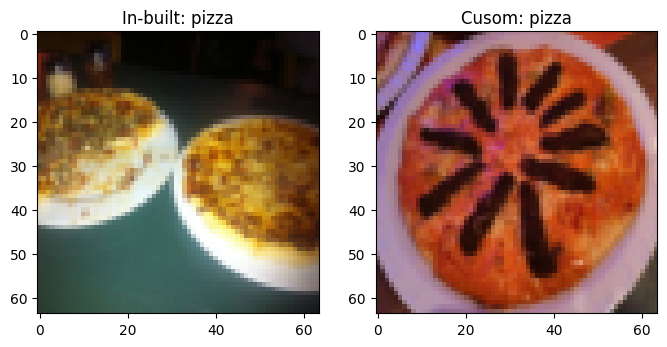

In [40]:
fig, axs = plt.subplots(1,2,figsize=(8,8))
axs[0].imshow(train_data[0][0].permute(1, 2, 0))
axs[0].set_title(f'In-built: {train_data.classes[train_data[0][1]]}')

axs[1].imshow(train_data_custom[0][0].permute(1, 2, 0))
axs[1].set_title(f'Cusom: {train_data_custom.classes[train_data_custom[0][1]]}')

plt.show()

In [44]:
next(iter(test_data_loader))[0].shape, next(iter(test_data_loader_custom))[0].shape

(torch.Size([16, 3, 64, 64]), torch.Size([16, 3, 64, 64]))

# Multiple data augmentation methods

In [48]:
# with augmentation
data_transform_augment = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=32),
    transforms.ToTensor()
])
# without augmentation
data_transform_simple = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

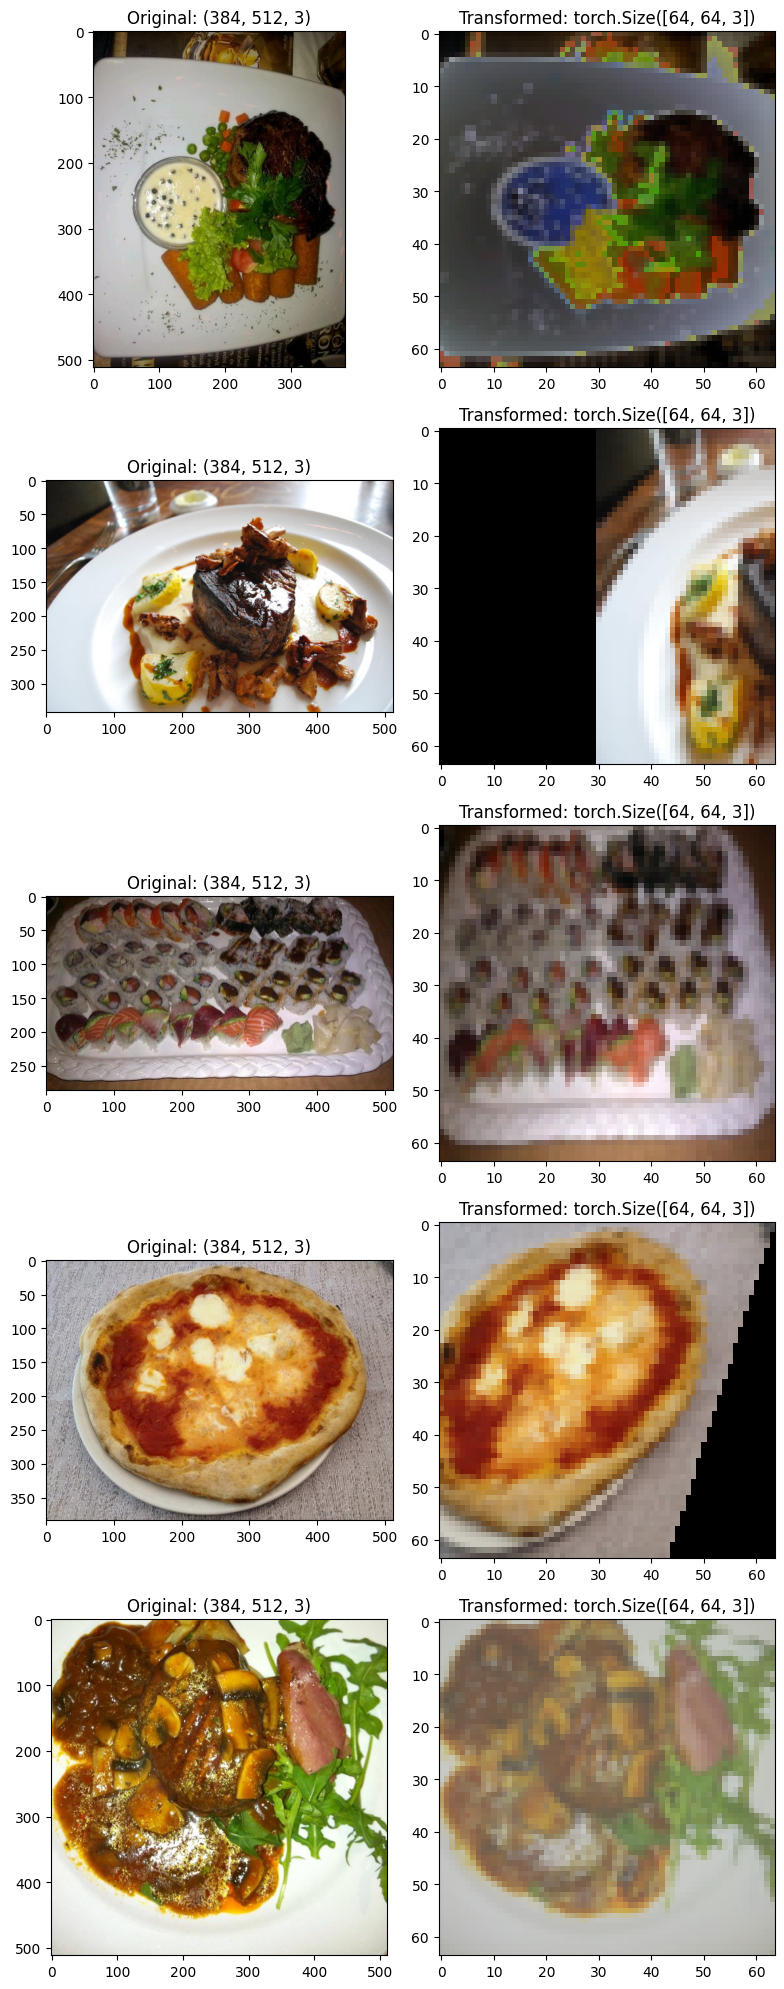

In [47]:
# see samples
sample_data = random.sample(train_image_path, k=5)

fig, axs = plt.subplots(5,2, figsize=(8,20))
for i in range(5):
  img = Image.open(sample_data[i])
  # original
  # img_as_array = np.asarray(img)
  axs[i][0].imshow(img)
  axs[i][0].set_title(f'Original: {img_as_array.shape}')
  # transformed
  img_tensor = data_transform_augment(img).permute(1, 2, 0)
  axs[i][1].imshow(img_tensor)
  axs[i][1].set_title(f'Transformed: {img_tensor.shape}')
plt.tight_layout()
plt.show()

# Modeling

### Declare model

In [120]:
# image -> tensor
train_data_simple = datasets.ImageFolder(root=train_dir, transform=data_transform_simple)
train_data_aug = datasets.ImageFolder(root=train_dir, transform=data_transform_augment)

test_data = datasets.ImageFolder(root=test_dir, transform=data_transform_simple)

# data loader
train_data_loader_simple = DataLoader(dataset=train_data_simple, batch_size=16, num_workers=os.cpu_count())
train_data_loader_aug = DataLoader(dataset=train_data_aug, batch_size=16, num_workers=os.cpu_count())

test_data_loader = DataLoader(dataset=test_data, batch_size=16, num_workers=os.cpu_count())

In [74]:
import torch.nn as nn

class Model(nn.Module):
  def __init__(self, in_shape, out_shape, hidden_units):
    super().__init__()
    self.block_cnn = nn.Sequential(
        nn.Conv2d(in_channels=in_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.block_mlp = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*16*16, out_features=out_shape)
    )
  def forward(self, x):
    x = self.block_cnn(x)
    x = self.block_mlp(x)
    return x

model_simple = Model(in_shape=3, out_shape=len(train_data_simple.classes), hidden_units=10).to(device)
model_aug = Model(in_shape=3, out_shape=len(train_data_aug.classes), hidden_units=10).to(device)

In [75]:
# Install torchinfo if it's not available, import it if it is
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model_simple, input_size=[16, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [16, 3]                   --
├─Sequential: 1-1                        [16, 10, 16, 16]          --
│    └─Conv2d: 2-1                       [16, 10, 64, 64]          280
│    └─ReLU: 2-2                         [16, 10, 64, 64]          --
│    └─Conv2d: 2-3                       [16, 10, 64, 64]          910
│    └─ReLU: 2-4                         [16, 10, 64, 64]          --
│    └─Conv2d: 2-5                       [16, 10, 64, 64]          910
│    └─ReLU: 2-6                         [16, 10, 64, 64]          --
│    └─MaxPool2d: 2-7                    [16, 10, 32, 32]          --
│    └─Conv2d: 2-8                       [16, 10, 32, 32]          910
│    └─ReLU: 2-9                         [16, 10, 32, 32]          --
│    └─Conv2d: 2-10                      [16, 10, 32, 32]          910
│    └─ReLU: 2-11                        [16, 10, 32, 32]          --
│    └─Con

### Train the models

In [121]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score

def train_step(model, data, optimizer, loss_fn, device):
  model.train()
  losses = []
  for X,y in data:
    X,y = X.to(device), y.to(device)
    # pred
    y_logit = model(X)
    loss = loss_fn(y_logit, y)
    losses.append(loss.cpu().detach().numpy())
    # gradient
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  return np.mean(losses)

def test_step(model, data, loss_fn, device):
  model.eval()
  losses = []
  with torch.inference_mode():
    for X,y in data:
      X,y = X.to(device), y.to(device)
      # pred
      y_logit = model(X)
      loss = loss_fn(y_logit, y)
      losses.append(loss.cpu().detach().numpy())
  return np.mean(losses)

def train(model, train_data, test_data, optimizer, loss_fn, device, epochs):
  train_losses = []
  test_losses = []
  for epoch in tqdm(range(epochs)):
    # train step
    train_loss = train_step(model, train_data, optimizer, loss_fn, device)
    train_losses.append(train_loss)
    # test step
    test_loss = test_step(model, train_data, loss_fn, device)
    test_losses.append(test_loss)
  return train_losses, test_losses

def evaluate(model, data, loss_fn, accuracy_fn, device):
  model.eval()
  losses = []
  accuracies = []
  with torch.inference_mode():
    for X,y in data:
      X,y = X.to(device), y.to(device)
      # pred
      y_logit = model(X)
      # loss
      loss = loss_fn(y_logit, y)
      losses.append(loss.cpu().detach().numpy())
      # accuracy
      accuracies.append(accuracy_fn(y.cpu(), torch.argmax(y_logit, dim=1).cpu()))
  return np.mean(losses), np.mean(accuracies)

def plot_training(training_loss, test_loss, title):
  plt.figure(figsize=(10,4))
  plt.plot(range(1, 21), training_loss, label='train loss')
  plt.plot(range(1, 21), test_loss, label='test loss')
  plt.xlabel('Epochs')
  plt.title(title)
  plt.legend()
  plt.show()

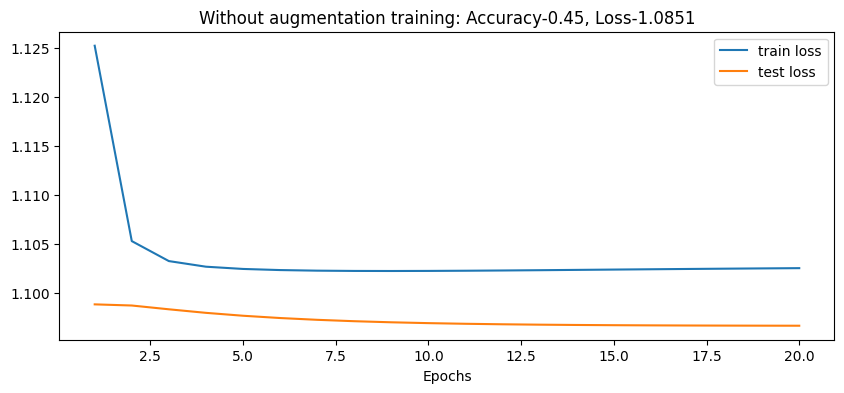

In [128]:
# simple model
optimizer = torch.optim.Adam(params = model_simple.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
epochs=20
simple_train_losses, simple_test_losses = train(model=model_simple,
      train_data=train_data_loader_simple,
      test_data=test_data_loader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      device=device,
      epochs=epochs)

simple_loss, simple_acc = evaluate(model=model_simple,
                                   data=test_data_loader,
                                   loss_fn=loss_fn,
                                   accuracy_fn=accuracy_score,
                                   device=device)

plot_training(training_loss=simple_train_losses,
              test_loss=simple_test_losses,
              title=f'Without augmentation training: Accuracy-{simple_acc}, Loss-{simple_loss:.05}')

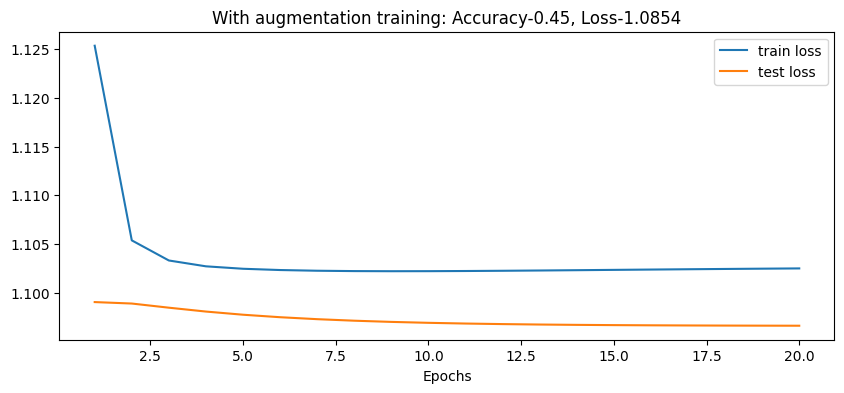

In [126]:
# agmented model
optimizer = torch.optim.Adam(params = model_aug.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()
epochs=20
aug_train_losses, aug_test_losses = train(model=model_aug,
      train_data=train_data_loader_aug,
      test_data=test_data_loader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      device=device,
      epochs=epochs)

aug_loss, aug_acc = evaluate(model=model_aug,
                                   data=test_data_loader,
                                   loss_fn=loss_fn,
                                   accuracy_fn=accuracy_score,
                                   device=device)

plot_training(training_loss=aug_train_losses,
              test_loss=aug_test_losses,
              title=f'With augmentation training: Accuracy-{aug_acc}, Loss-{aug_loss:.05}')

### Custom image

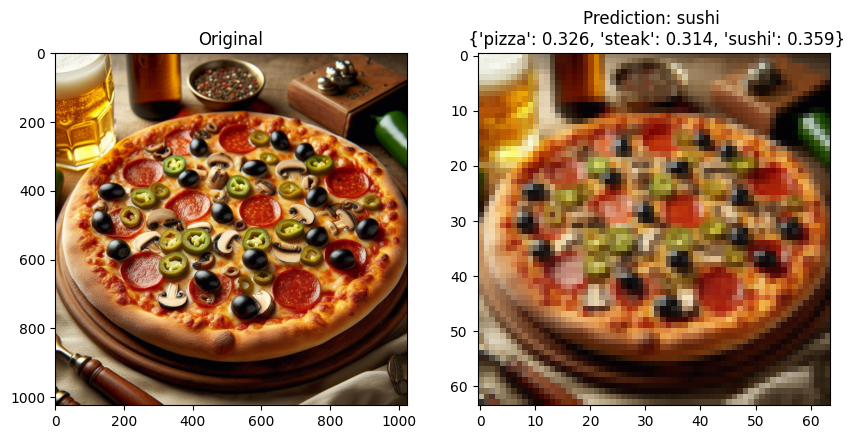

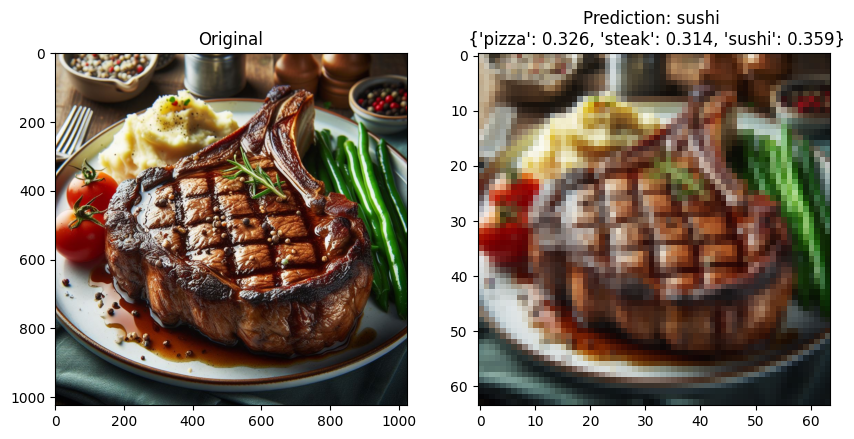

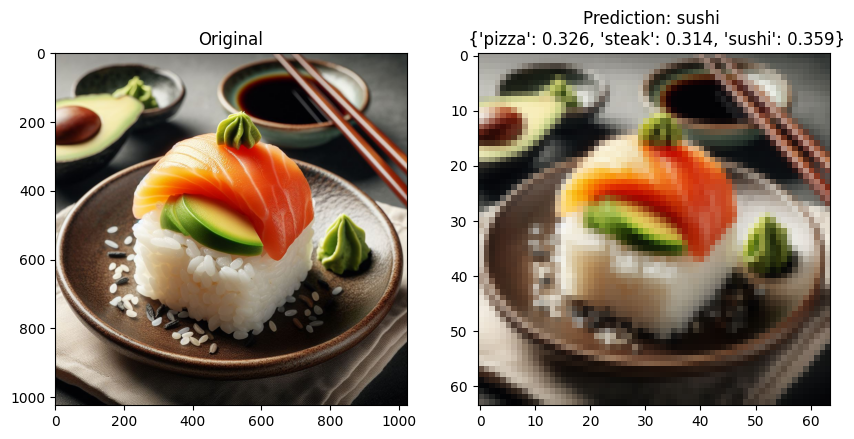

In [168]:
def sample_predict(path,
                   label,
                   model=model_simple,
                   transform=data_transform_simple,
                   classes=test_data.classes,
                   class_to_idx=test_data.class_to_idx,
                   ):
  # get the image
  sample_path = Path(path)
  sample_img = Image.open(sample_path)
  sample_data = transform(sample_img)

  # prepare data
  sample_data_loader = DataLoader(dataset=sample_data, batch_size=16, num_workers=os.cpu_count())
  X_sample = next(iter(sample_data_loader)).to(device)
  y_sample = class_to_idx[label]

  # predict
  y_logit = model(X_sample.unsqueeze(dim=0))
  y_proba = torch.softmax(y_logit,dim=1).cpu().squeeze().detach().numpy()
  y_pred = np.argmax(y_proba)
  label_probas = {label: round(y_proba[idx], 3) for label, idx in class_to_idx.items()}

  # plot
  fig, axs = plt.subplots(1,2, figsize=(10,10))
  axs[0].imshow(sample_img)
  axs[0].set_title(f'Original')
  axs[1].imshow(sample_data.permute(1, 2, 0))
  axs[1].set_title(f'Prediction: {classes[y_pred]} \n {label_probas}')
  plt.show()

# try it out
sample_predict(path="pizza.jpeg", label='pizza')
sample_predict(path="steak.jpeg", label='steak')
sample_predict(path="sushi.jpeg", label='sushi')

# CONCLUSION - Model is NOT working